<a href="https://colab.research.google.com/github/Kulabus/Kulabus/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B0_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Анализ датасета IMDB посредством библиотеки Pandas

Используя базу данных фильмов IMDB, проверим следующие гипотезы:

1. Большинство фильмов выпускаются по пятницам
2. Известные актеры снимаются в самых кассовых фильмах
3. Известные актеры снимаются в самыx дорогих фильмах


### Загрузка данных и формирование датасетов

In [ ]:
from requests import get
response = get("https://storage.yandexcloud.net/academy.ai/the_movies_dataset.zip")

with open('the_movies_dataset.zip', 'wb') as f:
    f.write(response.content)

# Разархивация датасета в директорию 'the_movies_dataset'
!unzip -qo "the_movies_dataset.zip" -d ./the_movies_dataset

# Папка с распакованным датасетом
FILE_PATH = './the_movies_dataset'

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
df = pd.read_csv(f'{FILE_PATH}/movies_metadata.csv')

df = df.drop(['imdb_id',
              'adult',
              'belongs_to_collection',
              'homepage', 'video',
              'poster_path',
              'production_companies',
              'genres',
              'production_countries',
              'tagline',
              'spoken_languages',
              'original_language',
              'overview',
              'original_title',
              'runtime',
              'vote_average',
              'vote_count',
              'status'], axis=1)

In [ ]:
df[['budget', 'popularity']]

,budget,popularity
0,30000000,21.946943
1,65000000,17.015539
2,0,11.7129
3,16000000,3.859495
4,0,8.387519
...,...,...
45461,0,0.072051
45462,0,0.178241
45463,0,0.903007
45464,0,0.003503


### Гипотеза 1. Большинство фильмов выпускаются по пятницам

<Axes: title={'center': 'Дни релиза фильмов'}, xlabel='day_of_week'>

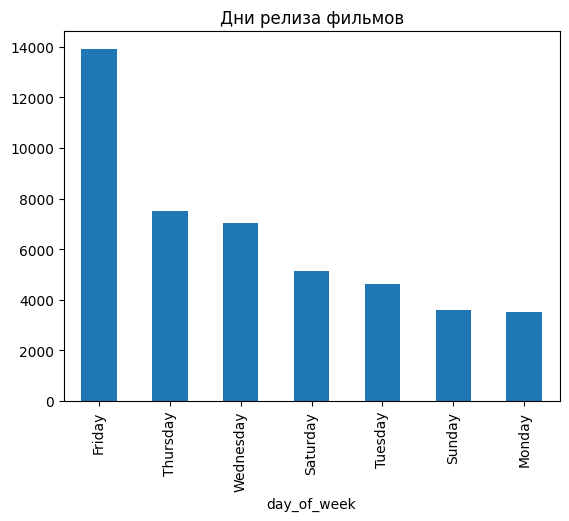

In [ ]:
# Используем метод day_name().
df['day_of_week'] = pd.to_datetime(df['release_date'], errors='coerce').dt.day_name()

# Выводим полученные данные на гистограмму
plt.title('Дни релиза фильмов')
df.groupby('day_of_week').count().sort_values(['title'], ascending=False)['title'].plot(kind='bar')

<h3>Выводы по проверке гипотезы</h3>
Как мы видим, наиболее часто релизы фильмов выпадают именно на пятницу. Гипотеза подтверждена 👍

### Гипотеза 2. Известные актеры снимаются в самых кассовых фильмах

Известность актёра - очень расплывчатый критерий. Чтобы как-то его измерить введём некоторые параметры оценки.

В базе данных есть столбец, отображающий популярность фильмов - примем её за основной показатель, дающий актерам известность. Далее выделим из актёрского состава каждого фильма имена, встречающиеся в титрах на первых позициях. Возьмём первые шесть позиций в титрах и присвоим каждому коэффициент, рассчитанный по формуле `(6 - i) / 2`. Далее эти коэффициенты умножим на значение популярности фильма. Так получим условные "баллы" рейтинга актёров, полученные ими за игру в конкретном фильме. Далее просуммируем для каждого актёра его "баллы" и получим суммарный рейтинг от всех фильмов.

Внесём данные о рейтинге актёров в таблицу, где для каждого фильма существует по 6 строк с разными актёрами, сыгравшими в них первые роли, бюджетом и рейтингом актёра. На основании данных о бюджете фильма и рейтинге его актёров построим диаграмму.

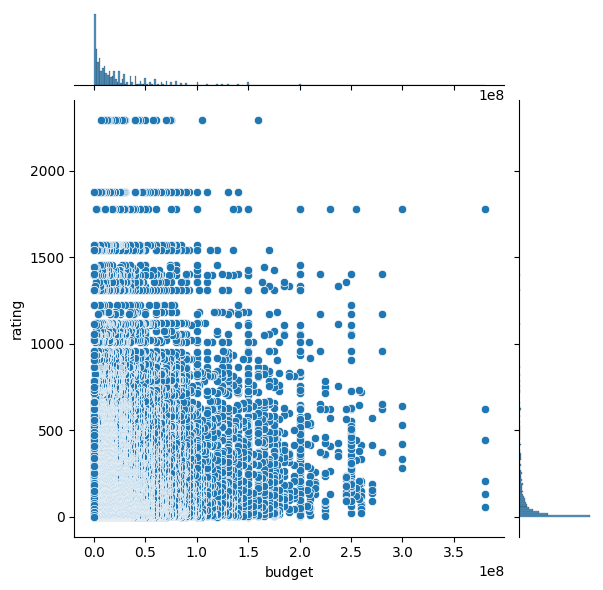

In [ ]:
# Подготовка столбцов revenue и budget к анализу
df['revenue'] = df['revenue'].replace(0, np.nan) # Меняем все значения, равные 0 на NaN
df['budget'] = pd.to_numeric(df['budget'], errors='coerce') # Пытаемся преобразовать в число, в случае ошибки принуждаем (coerce) к NaN
df['budget'] = df['budget'].replace(0, np.nan) # Заменяем 0 на NaN
df[df['budget'].isnull()].shape # Получаем только записи с numpy.NaN или Python None

# Создадим датафрейм с данными из файла credits.csv
cred = pd.read_csv(f'{FILE_PATH}/credits.csv')
cred = cred.drop(['crew'], axis=1)
df = df.drop(['release_date'], axis=1)

# Создадим общий датафрейм data из двух - df и cred
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

df['id'] = df['id'].apply(convert_int)  # Преобразуем к int
df = df.drop(df[df['id'].isnull()].index) # Удалим все элементы с "id" NaN
df['id'] = df['id'].astype('int') # установим тип
data = df.merge(cred, on='id') # объединим датафреймы

# Преобразуем cast из string в list
import ast
data['cast'] = data['cast'].apply(ast.literal_eval) # Строку в словарь '{"a": 1}' -> {'a': 1}

# Создадим три столбца с именами первых трёх атёров, упоминаемых в фильме и три столбца с соответствующими индексами: 3 - для первого, 2 - для второго, 3 - для третьего

def create_order(x, k): # k - номер order актёра в титрах фильма
    for i in x:
        if i['order'] == k:
            return i['name']

for i in range(6):
    data['name_'+str(i)] = data['cast'].apply(lambda x: create_order(x, i))

def create_order_rating(x, k): # k - номер order актёра в титрах фильма
    for i in x:
        if i['order'] == k:
            return (6 - i['order']) / 2

for i in range(6):
    data['rating_'+str(i)] = data['cast'].apply(lambda x: create_order_rating(x, i))

# Преобразуем все значения столбца popularity к типу int
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

data['popularity'] = data['popularity'].apply(convert_int)  # Преобразуем к int

# Умножим все три индекса порядка в титрах фильма на значение популярности этого фильма
for i in range(6):
    data['rating_'+str(i)] = data['rating_'+str(i)] * data['popularity']

# Убираем все строки, где popularity и budget соответствуют NaN и сортируем датафрейм по popularity
budg = data[data['popularity'].notnull() & data['budget'].notnull()].sort_values(['popularity'], ascending=False)

# Для каждого актёра и его рейтинга в текущем фильме создадим отдельный датафрейм, куда добавим бюджет и название фильма
a = pd.DataFrame({'title': budg['title'], 'budget': budg['budget'], 'name': budg['name_0'], 'rating': budg['rating_0']})
b = pd.DataFrame({'title': budg['title'], 'budget': budg['budget'], 'name': budg['name_1'], 'rating': budg['rating_1']})
c = pd.DataFrame({'title': budg['title'], 'budget': budg['budget'], 'name': budg['name_2'], 'rating': budg['rating_2']})
d = pd.DataFrame({'title': budg['title'], 'budget': budg['budget'], 'name': budg['name_3'], 'rating': budg['rating_3']})
e = pd.DataFrame({'title': budg['title'], 'budget': budg['budget'], 'name': budg['name_4'], 'rating': budg['rating_4']})
f = pd.DataFrame({'title': budg['title'], 'budget': budg['budget'], 'name': budg['name_5'], 'rating': budg['rating_5']})

# Объединим фреймы в общий
budg = pd.concat([a, b, c, d, e, f]).sort_values(['budget'], ascending=False)
budg.drop(budg[budg['name'].isnull() | budg['rating'].isnull()].index, inplace=True) # Убираем все строки, в которых name или rating соответсвтуют NaN или None

# Создадим новый фрейм из сводной таблицы budg с именами актеров и их совокупным рейтингом по всем представленным фильмам
actors_budg_rating = pd.pivot_table(budg, index=['name'], values=['rating'], aggfunc=np.sum).sort_values('rating', ascending=False)
actors_budg_rating['rating'] = actors_budg_rating['rating'].apply(int)

budg['rating'] = budg['name'].apply(lambda x: actors_budg_rating.loc[x]) # Заменяем рейтинг каждого актёра на его совокупный рейтинг

# Выводим результат на диаграмму
%matplotlib inline
import matplotlib.pyplot as plt # Библиотека для построения графиков
import seaborn as sns # Еще одна библиотека для построения графиков, работает как обертка над предыдущей

budg_mat = budg[((budg['rating'] < 1750) & (budg['budget'] < 301000000) & (budg['budget'] > 100000))]
sns.jointplot(x='budget', y='rating', data=budg, kind='scatter') # график совместного распределения по двум переменным
plt.show() # Показать построенный график

<h3>Выводы по проверке гипотезы</h3>
Исходя из полученной диаграммы можно сделать выводы об ошибочности гепотезы. Хотя с популярностью актёров, как правило, растёт и их гонорар, однако, чаще бюджет фильма растёт на других основаниях: фильм может быть частью очень успешной франшизы, крупный режиссёр тратит много денег на производство фильма и проч.

### Гипотеза 3. Известные актеры снимаются в самыx дорогих фильмах

Используя промежуточные данные из датафрейма data, повторим дальнейшие действия аналогично гипотезе 2.

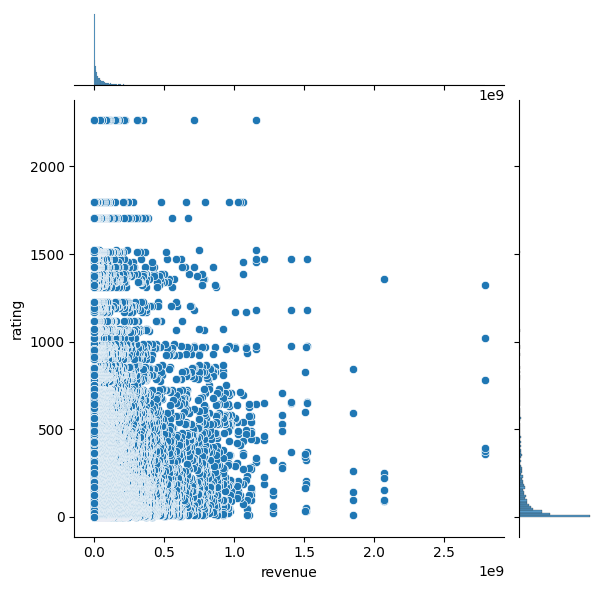

In [ ]:
# Убираем все строки, где popularity и revenue соответствуют NaN и сортируем датафрейм по popularity
rev = data[data['popularity'].notnull() & data['revenue'].notnull()].sort_values(['popularity'], ascending=False)

# Для каждого актёра и его рейтинга в текущем фильме создадим отдельный датафрейм, куда добавим сборы и название фильма
a = pd.DataFrame({'title': rev['title'], 'revenue': rev['revenue'], 'name': rev['name_0'], 'rating': rev['rating_0']})
b = pd.DataFrame({'title': rev['title'], 'revenue': rev['revenue'], 'name': rev['name_1'], 'rating': rev['rating_1']})
c = pd.DataFrame({'title': rev['title'], 'revenue': rev['revenue'], 'name': rev['name_2'], 'rating': rev['rating_2']})
d = pd.DataFrame({'title': rev['title'], 'revenue': rev['revenue'], 'name': rev['name_3'], 'rating': rev['rating_3']})
e = pd.DataFrame({'title': rev['title'], 'revenue': rev['revenue'], 'name': rev['name_4'], 'rating': rev['rating_4']})
f = pd.DataFrame({'title': rev['title'], 'revenue': rev['revenue'], 'name': rev['name_5'], 'rating': rev['rating_5']})

# Объединим фреймы в общий
rev = pd.concat([a, b, c, d, e, f]).sort_values(['revenue'], ascending=False)
rev.drop(rev[rev['name'].isnull() | rev['rating'].isnull()].index, inplace=True) # Убираем все строки, в которых name или rating соответсвтуют NaN или None

# Создадим новый фрейм из сводной таблицы rev с именами актеров и их совокупным рейтингом по всем представленным фильмам
actors_rev_rating = pd.pivot_table(rev, index=['name'], values=['rating'], aggfunc=np.sum).sort_values('rating', ascending=False)
actors_rev_rating['rating'] = actors_rev_rating['rating'].apply(int)

rev['rating'] = rev['name'].apply(lambda x: actors_rev_rating.loc[x]) # Заменяем рейтинг каждого актёра на его совокупный рейтинг

# Выводим результат на диаграмму
%matplotlib inline
import matplotlib.pyplot as plt # Библиотека для построения графиков
import seaborn as sns # Еще одна библиотека для построения графиков, работает как обертка над предыдущей

# “scatter” | “kde” | “hist” | “hex” | “reg” | “resid”
rev_mat = rev[((rev['rating'] < 1750) & (rev['revenue'] < 301000000) & (rev['revenue'] > 100000))]
sns.jointplot(x='revenue', y='rating', data=rev, kind='scatter') # график совместного распределения по двум переменным
plt.show() # Показать построенный график

<h3>Выводы по проверке гипотезы</h3>
Исходя из полученной диаграммы можно сделать выводы об ошибочности гепотезы. Хотя с популярные актёры, как правило, привлекают к фильму большое фнимание, однако, кассовые сборы фильма гораздо больше зависят от других параметров: фильм может быть частью очень успешной франшизы, именитый режиссёр снимает очередной шедевр и проч.